## Pattern Separation Results

In [3]:
# import necessary libraries:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
OUTDATED_IGNORE=1
from pingouin import ttest

In [4]:
# add figure path
figurepath = 'C:/Users/tuq67942/OneDrive - Temple University/Documents/Figures/'
# import dfs
PSagedf = pd.read_csv('csvs/PSoutputdf_exactage.csv')
PSdf = pd.read_csv('csvs/PSoutputdf.csv')
PSdelaydf = pd.read_csv('csvs/PSdelaydf.csv')
stackeddf = pd.read_csv('csvs/PS_cat_Year_1.csv')

# Age, and Sex breakdown of participants - and of those who did/did not experience the delay:

In [5]:
d = {'Among all participants:':stackeddf,
    'Among participants who experienced a delay between encoding and retrieval:':
     stackeddf[stackeddf['Delay']==True],
    'Among participants who did not experienced a delay between encoding and retrieval:':
     stackeddf[stackeddf['Delay']==False]}

for k,df in d.items():
    print(k)
    print('N = '+str(len(df)))
    print('Ages ranged from: '+str(np.min(df['Age']))+' - '+\
          str(np.max(df['Age']))+' years, Mean = '+\
          str(np.round(np.mean(df['Age']),2))+\
          ' +/- '+str(np.round(np.std(df['Age']),2)))
    print(df['Sex'].value_counts())


Among all participants:
N = 91
Ages ranged from: 4.0 - 7.9 years, Mean = 5.83 +/- 1.21
Girl    57
Boy     34
Name: Sex, dtype: int64
Among participants who experienced a delay between encoding and retrieval:
N = 49
Ages ranged from: 4.07 - 7.88 years, Mean = 5.65 +/- 1.19
Girl    32
Boy     17
Name: Sex, dtype: int64
Among participants who did not experienced a delay between encoding and retrieval:
N = 42
Ages ranged from: 4.0 - 7.9 years, Mean = 6.03 +/- 1.2
Girl    25
Boy     17
Name: Sex, dtype: int64


## Proportion selected of Target, Lure, and Foil for pattern separation
#### Stars indicate delay of 1 week between encoding and retrieval 

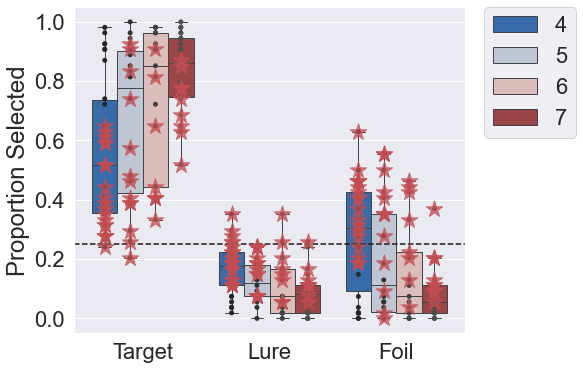

In [6]:
order = ['Target','Lure','Foil']
orderage = [4,5,6,7]

sns.set(font_scale=2)
fig, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(data=PSdf, x="Selection", y="Proportion Selected", hue="Age", palette="vlag",order=order, showfliers = False)
sns.stripplot(data=PSdf, x="Selection", y="Proportion Selected", hue="Age", dodge=True,palette='dark:.3',order=order, jitter=False,legend=False)
vs = {k:[] for k in orderage}
for i,points in enumerate(ax.collections):
	vertices = points.get_offsets().data
	if len(vertices)>0:
		for ii,a in enumerate([4,7,6,5]):
			if (i+ii) % 4 == 0:
				vs[a].append(vertices[0][0])
for subject in PSdelaydf.Subject.unique():
	tmp = PSdelaydf[PSdelaydf.Subject == subject]
	age = tmp['Age'].iloc[0]
	for i,selection in enumerate(order):
		data = tmp[tmp.Selection==selection]['Proportion Selected'].iloc[0]
		ax.scatter(vs[age][i],data,marker='*',color='r',alpha=0.75, s=300,zorder=3)
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:4], labels[0:4], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set(xlabel=None)
plt.axhline(y=0.25, color='k', linestyle='--')
fig.savefig(figurepath+'PS_Target_Lure_Foil.png', bbox_inches='tight', dpi=100)

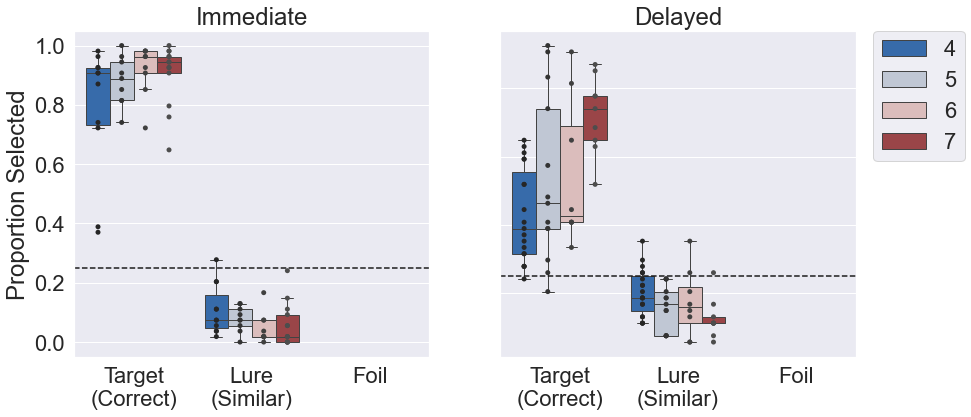

In [129]:
order = ['Target\n(Correct)','Lure\n(Similar)','Foil']
delaylabs = ['Immediate','Delayed']
orderage = [4,5,6,7]

sns.set(font_scale=2)
fig, ax = plt.subplots(1,2,figsize=(14, 6))
for i,delay in enumerate([False,True]):
    tmp = PSdf[PSdf['Delay']==delay]
    tmp = tmp.copy()
    tmp['Selection'] = tmp['Selection'].map({'Target': 'Target\n(Correct)', 'Lure': 'Lure\n(Similar)'})
    sns.boxplot(data=tmp, x="Selection", y="Proportion Selected", hue="Age", palette="vlag",order=order, showfliers = False, ax = ax[i], legend=delay)
    sns.stripplot(data=tmp, x="Selection", y="Proportion Selected", hue="Age", dodge=True,palette='dark:.3',order=order, jitter=False,legend=False, ax = ax[i])
    ax[i].set(xlabel=None)
    ax[i].axhline(y=0.25, color='k', linestyle='--')
    ax[i].set_title(delaylabs[i])
ax[i].set(yticklabels=[])
ax[i].set(ylabel=None)

handles, labels = ax[i].get_legend_handles_labels()
l = plt.legend(handles[0:4], labels[0:4], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


### Participants with 1 week delay are <i>clearly</i> off cieling, but is it significant?
### <b>Yes!</b>: Delay makes a significant difference in accuracy!

In [11]:
ttest(stackeddf[stackeddf['Delay']==True]['Target'],
      stackeddf[stackeddf['Delay']==False]['Target'])


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-9.387943,85.346058,two-sided,8.538514e-15,"[-0.42, -0.27]",1.920468,7.887e+11,1.0


In [105]:
ttest(stackeddf[stackeddf['Delay']==True]['Lure'],stackeddf[stackeddf['Delay']==False]['Lure'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,6.427407,88.648189,two-sided,6.339334e-09,"[0.07, 0.13]",1.341849,1.511e+06,1.0


## Question from Nora/Zoe December 2023:
### Is this difference significant in all age groups (4, 5, 6, 7 y.o.'s)?

In [66]:
ages = [4,5,6,7,8]
for i in range(len(ages)-1):
    tmpdf = stackeddf[stackeddf['Age'].between(ages[i], ages[i+1])]
    print('age = '+str(ages[i]))
    display(ttest(tmpdf[tmpdf['Delay']==True]['Target'],tmpdf[tmpdf['Delay']==False]['Target']))

age = 4


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-4.837206,14.826254,two-sided,0.000225,"[-0.51, -0.2]",2.068578,389.367,0.999412


age = 5


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-4.763463,15.594655,two-sided,0.000226,"[-0.51, -0.2]",1.773564,171.77,0.972999


age = 6


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-4.990884,7.471651,two-sided,0.001305,"[-0.64, -0.23]",2.775606,107.018,0.999158


age = 7


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-3.809381,16.405328,two-sided,0.001482,"[-0.28, -0.08]",1.677498,27.859,0.957004


In [91]:
import statsmodels.formula.api as sm2

result = sm2.ols(formula='Target~Delay+Age+Age*Delay',data=stackeddf).fit()
print(result.summary()) #no interaction!

                            OLS Regression Results                            
Dep. Variable:                 Target   R-squared:                       0.607
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     44.80
Date:                Thu, 11 Jan 2024   Prob (F-statistic):           1.33e-17
Time:                        09:35:44   Log-Likelihood:                 40.534
No. Observations:                  91   AIC:                            -73.07
Df Residuals:                      87   BIC:                            -63.02
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.6125      0.12

### Are 4-year-olds in the delay condition at chance?

In [87]:
tmpdf = stackeddf[stackeddf['Age'].between(4, 5)]
display(ttest(tmpdf[tmpdf['Delay']==True]['Target'],0.25))
print("4 year olds' performance is "+
      str(np.round(np.mean(tmpdf[tmpdf['Delay']==True]['Target']),2))+
     "+/-"+
     str(np.round(np.std(tmpdf[tmpdf['Delay']==True]['Target']),2)))

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,5.594998,18,two-sided,0.000026,"[0.36, 0.49]",1.283581,930.421,0.999546


4 year olds' performance is 0.43+/-0.13


# Let's just looks at those kids who had the delay going forward...

In [6]:
PSagedf = PSagedf[PSagedf['Delay']==True]
stackeddf = stackeddf[stackeddf['Delay']==True]

### plot correlation between age and Target/Lure/Foil proportion 

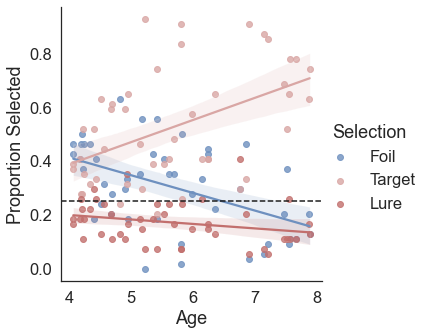

In [7]:
sns.set_theme(style="white",font_scale=1.5, palette=['#6e90bf',  '#d9a6a4', '#c26f6d'])
g = sns.lmplot(data=PSagedf,x="Age", y="Proportion Selected", hue="Selection")
plt.axhline(y=0.25, color='k', linestyle='--')
g.savefig(figurepath+'PS_corr_Target_Lure_Foil.png', bbox_inches='tight', dpi=100)

### Correlation between age and proportion selected of Foil, Target, and Lure:

In [8]:
PSkey = {-1:'Foil',1:'Target',0:'Lure'}
statlist = []
for selection in PSkey.values():
	tmpdf = PSagedf[PSagedf['Selection'] == selection]
	res = stats.pearsonr(tmpdf['Age'],tmpdf['Proportion Selected'])
	statlist.append({'Selection':selection, 'Age/Prop r':res[0], 'Age/Prop p':res[1]})
statdf=pd.DataFrame(statlist)
display(statdf)

,Selection,Age/Prop r,Age/Prop p
0,Foil,-0.491461,0.000451
1,Target,0.479992,0.000640
2,Lure,-0.258872,0.078911


In [9]:
import statsmodels.formula.api as sm2

result = sm2.ols(formula='Age~Foil+Target+Lure+Foil*Lure',data=stackeddf).fit()
print(result.summary()) #no interaction!

                            OLS Regression Results                            
Dep. Variable:                    Age   R-squared:                       0.247
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     4.699
Date:                Thu, 04 Jan 2024   Prob (F-statistic):            0.00633
Time:                        13:34:30   Log-Likelihood:                -68.006
No. Observations:                  47   AIC:                             144.0
Df Residuals:                      43   BIC:                             151.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.5867      1.368      3.352      0.0

### Is the relationship between Lures and age significantly different from the relationship between foils and age? <b>No!</b>
### <i>Code from chatGPT4!!</i>

In [10]:
import numpy as np
from scipy.stats import t

def fisher_z_transform(r):
    return 0.5 * np.log((1 + r) / (1 - r))

def williams_test(r1, r2, r12, n):
    """
    Williams' Test for dependent correlations.
    
    Parameters:
    r1: First correlation coefficient.
    r2: Second correlation coefficient.
    r12: Correlation coefficient between the two variables of interest.
    n: Sample size.
    
    Returns:
    t_value: Test statistic.
    p_value: Two-tailed p-value.
    """
    
    z1 = fisher_z_transform(r1)
    z2 = fisher_z_transform(r2)
    
    numerator = z1 - z2
    denominator = np.sqrt((1 / (n - 3)) * (2 * (1 - r1) / (1 + r1) + 2 * (1 - r2) / (1 + r2) - 2 * (1 - r12)))
    
    t_value = numerator / denominator
    df = n - 3  # Degrees of freedom
    p_value = (1 - t.cdf(abs(t_value), df)) * 2  # Two-tailed p-value
    
    return t_value, p_value

t_value, p_value = williams_test(statdf[statdf.Selection=='Foil']['Age/Prop r'].iloc[0], 
              statdf[statdf.Selection=='Lure']['Age/Prop r'].iloc[0], 
              stats.pearsonr(stackeddf['Foil'],stackeddf['Lure'])[0], 
             len(stackeddf))

print("Interaction between foil-selection and lure-selection:")
print(f"t-value: {t_value:.4f}")
print(f"p-value: {p_value:.4f}")

t_value, p_value = williams_test(statdf[statdf.Selection=='Target']['Age/Prop r'].iloc[0], 
              statdf[statdf.Selection=='Lure']['Age/Prop r'].iloc[0], 
              stats.pearsonr(stackeddf['Target'],stackeddf['Lure'])[0], 
             len(stackeddf))

print("Interaction between target-selection and lure-selection:")
print(f"t-value: {t_value:.4f}")
print(f"p-value: {p_value:.4f}")

Interaction between foil-selection and lure-selection:
t-value: -0.6354
p-value: 0.5285
Interaction between target-selection and lure-selection:
t-value: 6.3496
p-value: 0.0000


### Investigating potential differences between the selection of correct objects, locations, and animals by age:

,Selection,Age/Prop r,Age/Prop p
0,object,0.443177,0.001810
1,location,0.343089,0.018230
2,animal,0.523258,0.000161


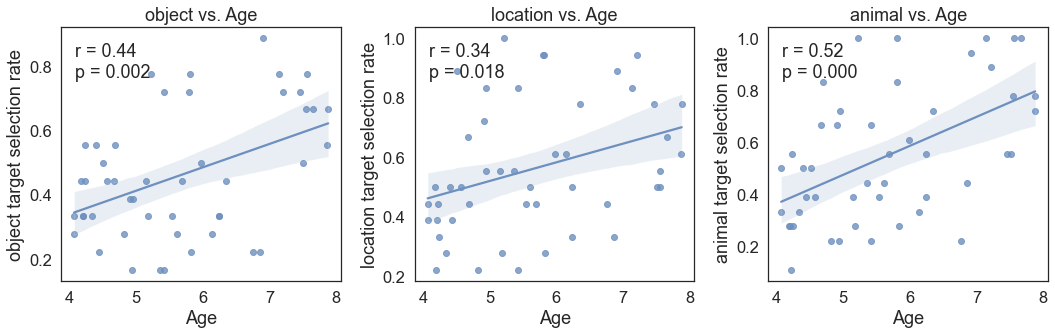

In [11]:
statlistola = []
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i,selection in enumerate(['object','location','animal']):
	res = stats.pearsonr(stackeddf['Age'],stackeddf[selection+' target selection rate'])
	statlistola.append({'Selection':selection, 'Age/Prop r':res[0], 'Age/Prop p':res[1]})
	sns.regplot(data=stackeddf, x='Age', y=selection+' target selection rate', ax=axes[i]).set_title(selection+' vs. Age')
	axes[i].text(0.05, 0.8, f'r = {res[0]:.2f}\np = {res[1]:.3f}', transform=axes[i].transAxes)
statdfola=pd.DataFrame(statlistola)
display(statdfola)

plt.tight_layout()
plt.show()

### Are any of these correlation value significantly different from one another? <b>No!</b>

In [12]:
pairs = [['object','location'],['object','animal'],['animal','location']]
for pair in pairs:
    t_value, p_value = williams_test(statdfola[statdfola.Selection==pair[0]]['Age/Prop r'].iloc[0], 
                  statdfola[statdfola.Selection==pair[1]]['Age/Prop r'].iloc[0], 
                  stats.pearsonr(stackeddf[pair[0]+' target selection rate'],
                                 stackeddf[pair[1]+' target selection rate'])[0], 
                 len(stackeddf))
    print(pair)
    print(f"t-value: {t_value:.4f}")
    print(f"p-value: {p_value:.4f}")

['object', 'location']
t-value: 0.7239
p-value: 0.4730
['object', 'animal']
t-value: -0.6722
p-value: 0.5050
['animal', 'location']
t-value: 1.4229
p-value: 0.1618


# Here: Analyzing only kids WITHOUT the delay

In [7]:
# re-import dfs
PSagedf = pd.read_csv('csvs/PSoutputdf_exactage.csv')
stackeddf = pd.read_csv('csvs/PS_cat_Year_1.csv')

PSagedf = PSagedf[PSagedf['Delay']==False]
stackeddf = stackeddf[stackeddf['Delay']==False]

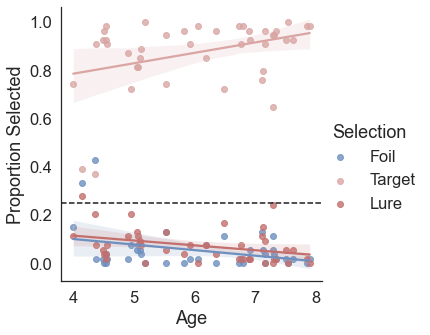

In [8]:
sns.set_theme(style="white",font_scale=1.5, palette=['#6e90bf',  '#d9a6a4', '#c26f6d'])
g = sns.lmplot(data=PSagedf,x="Age", y="Proportion Selected", hue="Selection")
plt.axhline(y=0.25, color='k', linestyle='--')

In [9]:
PSkey = {-1:'Foil',1:'Target',0:'Lure'}
statlist = []
for selection in PSkey.values():
	tmpdf = PSagedf[PSagedf['Selection'] == selection]
	res = stats.pearsonr(tmpdf['Age'],tmpdf['Proportion Selected'])
	statlist.append({'Selection':selection, 'Age/Prop r':res[0], 'Age/Prop p':res[1]})
statdf=pd.DataFrame(statlist)
display(statdf)

,Selection,Age/Prop r,Age/Prop p
0,Foil,-0.331479,0.031998
1,Target,0.368510,0.016335
2,Lure,-0.355925,0.020702


In [10]:
import statsmodels.formula.api as sm2

result = sm2.ols(formula='Age~Foil+Target+Lure+Foil*Lure',data=stackeddf).fit()
print(result.summary()) #no interaction!

                            OLS Regression Results                            
Dep. Variable:                    Age   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     2.057
Date:                Fri, 19 Jan 2024   Prob (F-statistic):              0.122
Time:                        11:06:32   Log-Likelihood:                -64.149
No. Observations:                  42   AIC:                             136.3
Df Residuals:                      38   BIC:                             143.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.7125      1.950      1.904      0.0

In [11]:
t_value, p_value = williams_test(statdf[statdf.Selection=='Foil']['Age/Prop r'].iloc[0], 
              statdf[statdf.Selection=='Lure']['Age/Prop r'].iloc[0], 
              stats.pearsonr(stackeddf['Foil'],stackeddf['Lure'])[0], 
             len(stackeddf))

print("Interaction between foil-selection and lure-selection:")
print(f"t-value: {t_value:.4f}")
print(f"p-value: {p_value:.4f}")

t_value, p_value = williams_test(statdf[statdf.Selection=='Target']['Age/Prop r'].iloc[0], 
              statdf[statdf.Selection=='Lure']['Age/Prop r'].iloc[0], 
              stats.pearsonr(stackeddf['Target'],stackeddf['Lure'])[0], 
             len(stackeddf))

print("Interaction between target-selection and lure-selection:")
print(f"t-value: {t_value:.4f}")
print(f"p-value: {p_value:.4f}")

NameError: name 'williams_test' is not defined

,Selection,Age/Prop r,Age/Prop p
0,object,0.173159,0.272797
1,location,0.458024,0.002287
2,animal,0.343800,0.025795


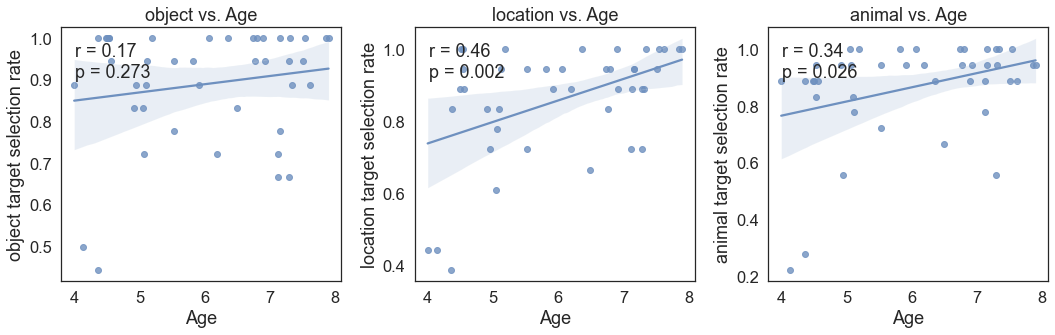

In [18]:
statlistola = []
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i,selection in enumerate(['object','location','animal']):
	res = stats.pearsonr(stackeddf['Age'],stackeddf[selection+' target selection rate'])
	statlistola.append({'Selection':selection, 'Age/Prop r':res[0], 'Age/Prop p':res[1]})
	sns.regplot(data=stackeddf, x='Age', y=selection+' target selection rate', ax=axes[i]).set_title(selection+' vs. Age')
	axes[i].text(0.05, 0.8, f'r = {res[0]:.2f}\np = {res[1]:.3f}', transform=axes[i].transAxes)
statdfola=pd.DataFrame(statlistola)
display(statdfola)

plt.tight_layout()
plt.show()

In [19]:
pairs = [['object','location'],['object','animal'],['animal','location']]
for pair in pairs:
    t_value, p_value = williams_test(statdfola[statdfola.Selection==pair[0]]['Age/Prop r'].iloc[0], 
                  statdfola[statdfola.Selection==pair[1]]['Age/Prop r'].iloc[0], 
                  stats.pearsonr(stackeddf[pair[0]+' target selection rate'],
                                 stackeddf[pair[1]+' target selection rate'])[0], 
                 len(stackeddf))
    print(pair)
    print(f"t-value: {t_value:.4f}")
    print(f"p-value: {p_value:.4f}")

['object', 'location']
t-value: -1.5630
p-value: 0.1261
['object', 'animal']
t-value: -0.8517
p-value: 0.3996
['animal', 'location']
t-value: -0.8036
p-value: 0.4265


## Nora question: Did the immediate group "learn to learn" - in other words is there a performance difference between session 1 and session 2?

In [12]:
for sel in ['Target','Lure','Foil']:
    print(sel)
    display(ttest(stackeddf[sel+' first'], stackeddf[sel+' second'], paired=True))
    print('Mean '+sel+' rate in first half:')
    print(np.round(np.mean(stackeddf[sel+' first']),2))
    print('+/-')
    print(np.round(np.std(stackeddf[sel+' first']),2))
    print('Mean '+sel+' rate in second half:')
    print(np.round(np.mean(stackeddf[sel+' second']),2))
    print('+/-')
    print(np.round(np.std(stackeddf[sel+' second']),2))
    
print('There is no change in Target/Lure/Foil selection rate\n'+
'between first and second session')

Target


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.053653,41,two-sided,0.298212,"[-0.01, 0.04]",0.100155,0.28,0.097169


Mean Target rate in first half:
0.88
+/-
0.14
Mean Target rate in second half:
0.87
+/-
0.16
Lure


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.098324,41,two-sided,0.922154,"[-0.02, 0.02]",0.011815,0.168,0.050641


Mean Lure rate in first half:
0.07
+/-
0.08
Mean Lure rate in second half:
0.07
+/-
0.07
Foil


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.274269,41,two-sided,0.209743,"[-0.04, 0.01]",0.153697,0.354,0.163477


Mean Foil rate in first half:
0.05
+/-
0.07
Mean Foil rate in second half:
0.06
+/-
0.11
There is no change in Target/Lure/Foil selection rate
between first and second session


## New Results requested by Nora and Zoe (in December 2023):
### Is the relationship between age and target/lure/foil selection significantly different between delay and no-delay group?

### 1) Is there an interaction between age and delay and target/lure/foil selection?

In [121]:
# re-import dfs
PSagedf = pd.read_csv('csvs/PSoutputdf_exactage.csv')
stackeddf = pd.read_csv('csvs/PS_cat_Year_1.csv')

for selection in PSkey.values():
    # Test for interaction:
    result = sm2.ols(formula=selection+' ~ Age + Delay + Age * Delay',
                     data=stackeddf).fit()    
    print(selection)
    print(result.summary()) 



Foil
                            OLS Regression Results                            
Dep. Variable:                   Foil   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     43.96
Date:                Thu, 11 Jan 2024   Prob (F-statistic):           2.18e-17
Time:                        13:42:17   Log-Likelihood:                 69.322
No. Observations:                  91   AIC:                            -130.6
Df Residuals:                      87   BIC:                            -120.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.1926     

### 2) 3 way interation: 'Proportion Selected' ~ Age + Delay + Selection (Foil or Lure) + Age X Delay X Selection (With Subject as grouping factor)

In [127]:
PSagedftmp = PSagedf.rename({'Proportion Selected':'PS'},axis=1)
PSagedftmp = PSagedftmp[~PSagedftmp.Selection.isin(["Target"])]
model = sm2.mixedlm("PS ~ Delay + Age + Selection + Delay*Age*Selection", PSagedftmp, groups=PSagedftmp["Subject"]) # Random Intercept
result = model.fit()
print(result.summary())

                    Mixed Linear Model Regression Results
Model:                    MixedLM         Dependent Variable:         PS      
No. Observations:         182             Method:                     REML    
No. Groups:               91              Scale:                      0.0055  
Min. group size:          2               Log-Likelihood:             153.7106
Max. group size:          2               Converged:                  Yes     
Mean group size:          2.0                                                 
------------------------------------------------------------------------------
                                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------
Intercept                            0.193    0.075  2.567 0.010  0.046  0.340
Delay[T.True]                        0.504    0.100  5.047 0.000  0.308  0.700
Selection[T.Lure]                    0.002    0.083  0.028 0.978 -0.160  

C:\Users\tuq67942\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


### None of the correlation values (age x accuracy correlation) are significantly different between delay and no-delay

In [94]:
# Code from chat GPT:
from scipy.stats import norm

# Function to transform Pearson r to Fisher Z
def r_to_z(r):
    return np.arctanh(r)

# Function to calculate standard error for Fisher Z
def standard_error(n):
    return 1/np.sqrt(n-3)

# Function to test the difference in correlation coefficients
def test_correlation_difference(r1, n1, r2, n2):
    z1 = r_to_z(r1)
    z2 = r_to_z(r2)
    se1 = standard_error(n1)
    se2 = standard_error(n2)

    # Calculate z-score for the difference
    z_diff = (z1 - z2) / np.sqrt(se1**2 + se2**2)
    p_value = 2 * (1 - norm.cdf(abs(z_diff)))

    return z_diff, p_value

for selection in PSkey.values():
	tmpdf = PSagedf[PSagedf['Selection'] == selection]
	tmpdf1 = tmpdf[tmpdf['Delay'] == False]
	res1 = stats.pearsonr(tmpdf1['Age'],tmpdf1['Proportion Selected'])[0]
	tmpdf2 = tmpdf[tmpdf['Delay'] == True]
	res2 = stats.pearsonr(tmpdf2['Age'],tmpdf2['Proportion Selected'])[0]
	z_diff, p_value = test_correlation_difference(res1, len(tmpdf1), res2, len(tmpdf2))
	print('Difference in correlations for: '+selection)
	print(f"Z-difference: {z_diff}, P-value: {p_value}")
    
tmpdf1 = stackeddf[stackeddf['Delay'] == False]
tmpdf2 = stackeddf[stackeddf['Delay'] == True]
for selection in ['object','location','animal']:
    res1 = stats.pearsonr(tmpdf1['Age'],tmpdf1[selection+' target selection rate'])[0]
    res2 = stats.pearsonr(tmpdf2['Age'],tmpdf2[selection+' target selection rate'])[0]
    z_diff, p_value = test_correlation_difference(res1, len(tmpdf1), res2, len(tmpdf2))
    print('Difference in correlations for: '+selection)
    print(f"Z-difference: {z_diff}, P-value: {p_value}")

Difference in correlations for: Foil
Z-difference: 1.0853999752613963, P-value: 0.2777445433493242
Difference in correlations for: Target
Z-difference: -0.9339605685603388, P-value: 0.3503242334648413
Difference in correlations for: Lure
Z-difference: -0.11690661617766708, P-value: 0.906934055157071
Difference in correlations for: object
Z-difference: -1.6581617651960265, P-value: 0.09728481984645976
Difference in correlations for: location
Z-difference: 0.3824759635740136, P-value: 0.7021083544074658
Difference in correlations for: animal
Z-difference: -1.3287092345948932, P-value: 0.18394391708567315


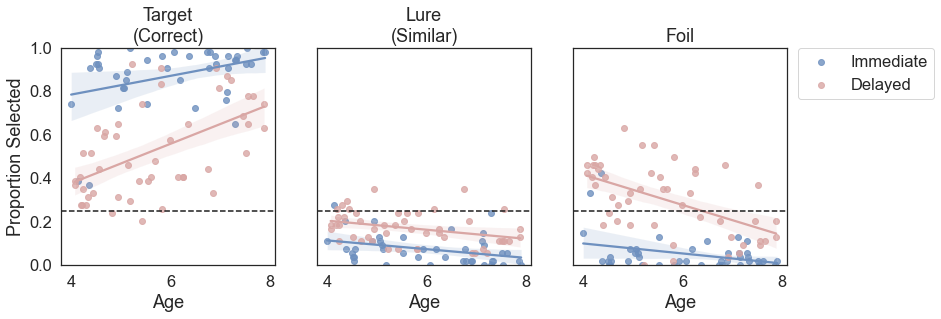

In [131]:
order = ['Target','Lure','Foil']
title = ['Target\n(Correct)', 'Lure\n(Similar)', 'Foil']
sns.set_theme(style="white",font_scale=1.5, palette=['#6e90bf',  '#d9a6a4', '#c26f6d'])
fig,ax=plt.subplots(1,3,figsize=(13, 4))
for i,selection in enumerate(order):
    tmp = PSagedf[PSagedf['Selection']==selection]
    sns.regplot(data=tmp[tmp['Delay']==False],x="Age", y="Proportion Selected",ax=ax[i],label='Immediate')
    sns.regplot(data=tmp[tmp['Delay']==True],x="Age", y="Proportion Selected",ax=ax[i],label='Delayed')
    ax[i].set_ylim([0,1])
    ax[i].axhline(y=0.25, color='k', linestyle='--')
    ax[i].set_title(title[i])
    if i>0:
        ax[i].set(yticklabels=[])
        ax[i].set(ylabel=None)
handles, labels = ax[i].get_legend_handles_labels()
l = plt.legend(handles[0:4], labels[0:4], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
